# Objectives

1. Plot the RTT Linear Regression
1. Plot rate variation

---
# Setup

## Import Modules

In [24]:
import os

import seaborn as sns
import matplotlib.pyplot as plt

import random
import json # Read clock model data
import scipy.stats # Regression line

## Input File Paths

In [8]:
tree_df_path = "../../docs/results/latest/timetree/timetree.tsv"
clock_model_path = "../../docs/results/latest/timetree/timetree_clock_model.json"
outdir = "../../docs/results/latest/timetree/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "timetree"

# Random
random.seed(1152342, 2)
np.random.seed(70262122)
st0 = np.random.get_state()


plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
plt.rc('legend', frameon=False) # legend frame

## Import Dataframe

In [5]:
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

---
# 1. Plot RTT Regression

In [14]:
with open(clock_model_path) as infile:
    regression = json.load(infile)

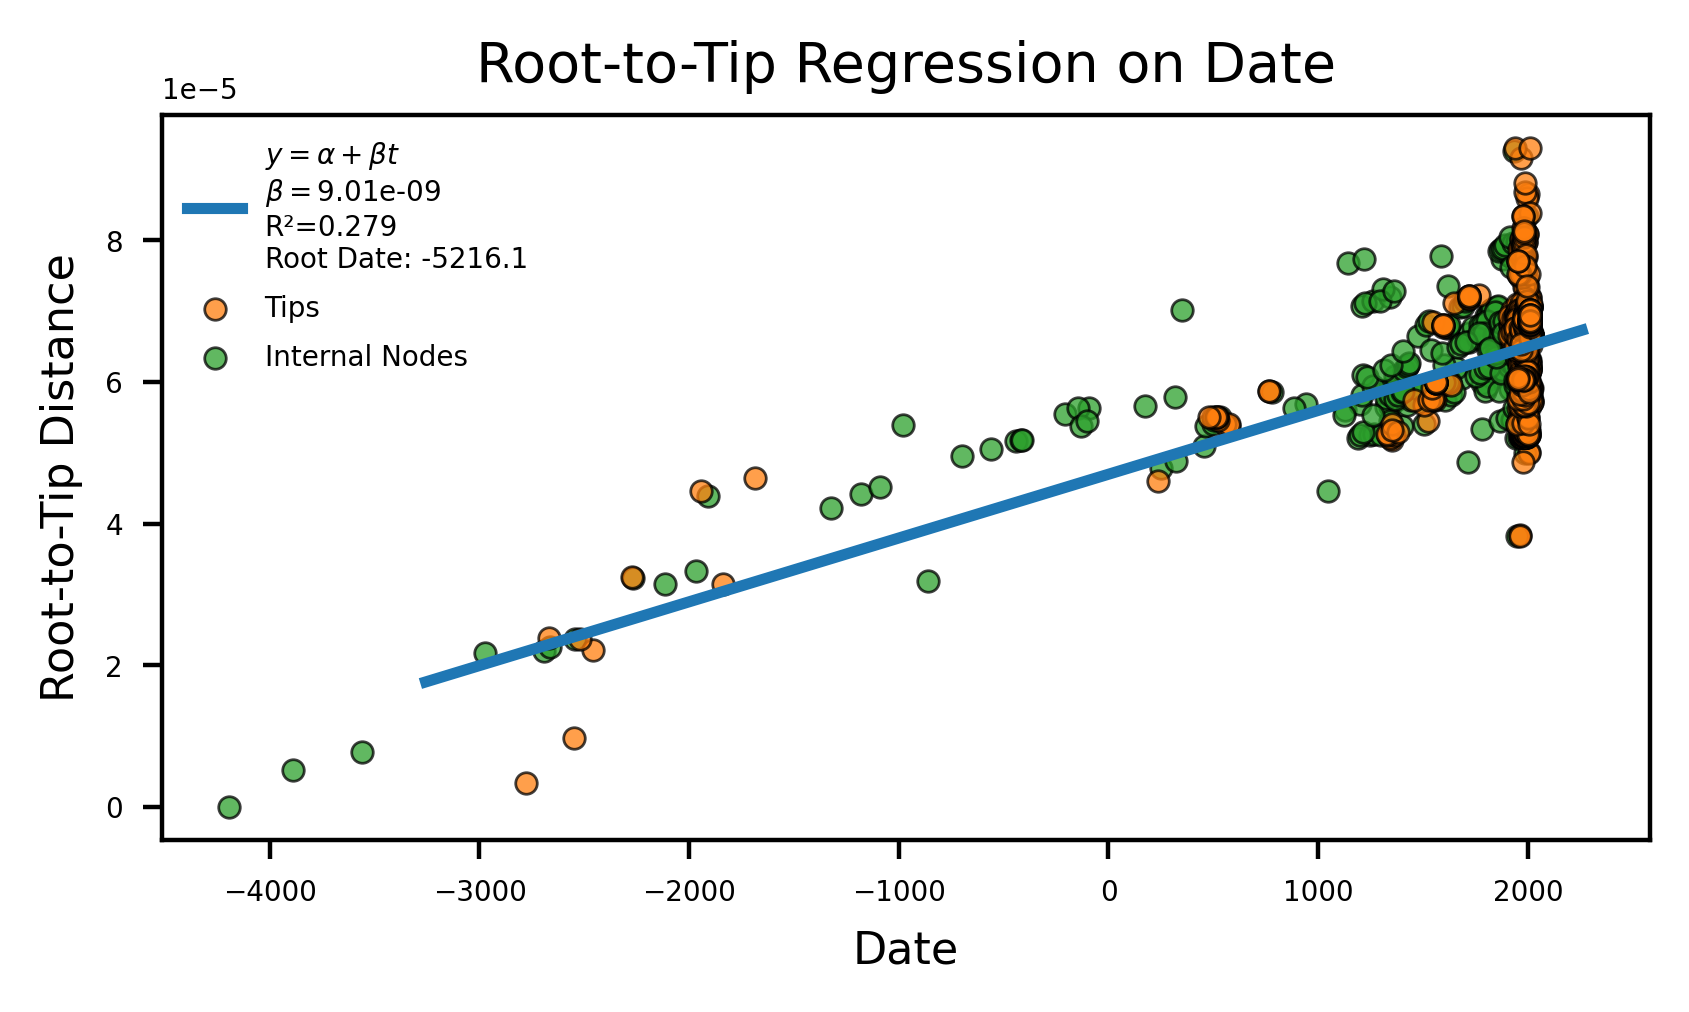

In [22]:
# Setup axis
fig, (ax1) = plt.subplots(1, dpi=dpi, figsize=figsize_mini)


# Make separate datasets for tips and internal nodes
tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) &
                   (tree_df["Branch_Support_Color"] == TERM_COL) ]

int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]

# Time to most recent common ancestor (x-intercept)
t_mrca = -regression['intercept']/regression['slope']

# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])

res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot internal nodes
ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=DISC_CMAPLIST[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)
# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=DISC_CMAPLIST[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.3f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=DISC_CMAPLIST[0],
         zorder=3,
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
ax1.set_title("Root-to-Tip Regression on Date")
# Legend
plt.legend(loc=2)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# 2. Plot Rate Variation

'\n# Save\nout_path = os.path.join(outdir, SCRIPT_NAME + "_rate_variation." + FMT) \nplt.savefig(out_path, \n        dpi=dpi, \n        bbox_inches = "tight")'

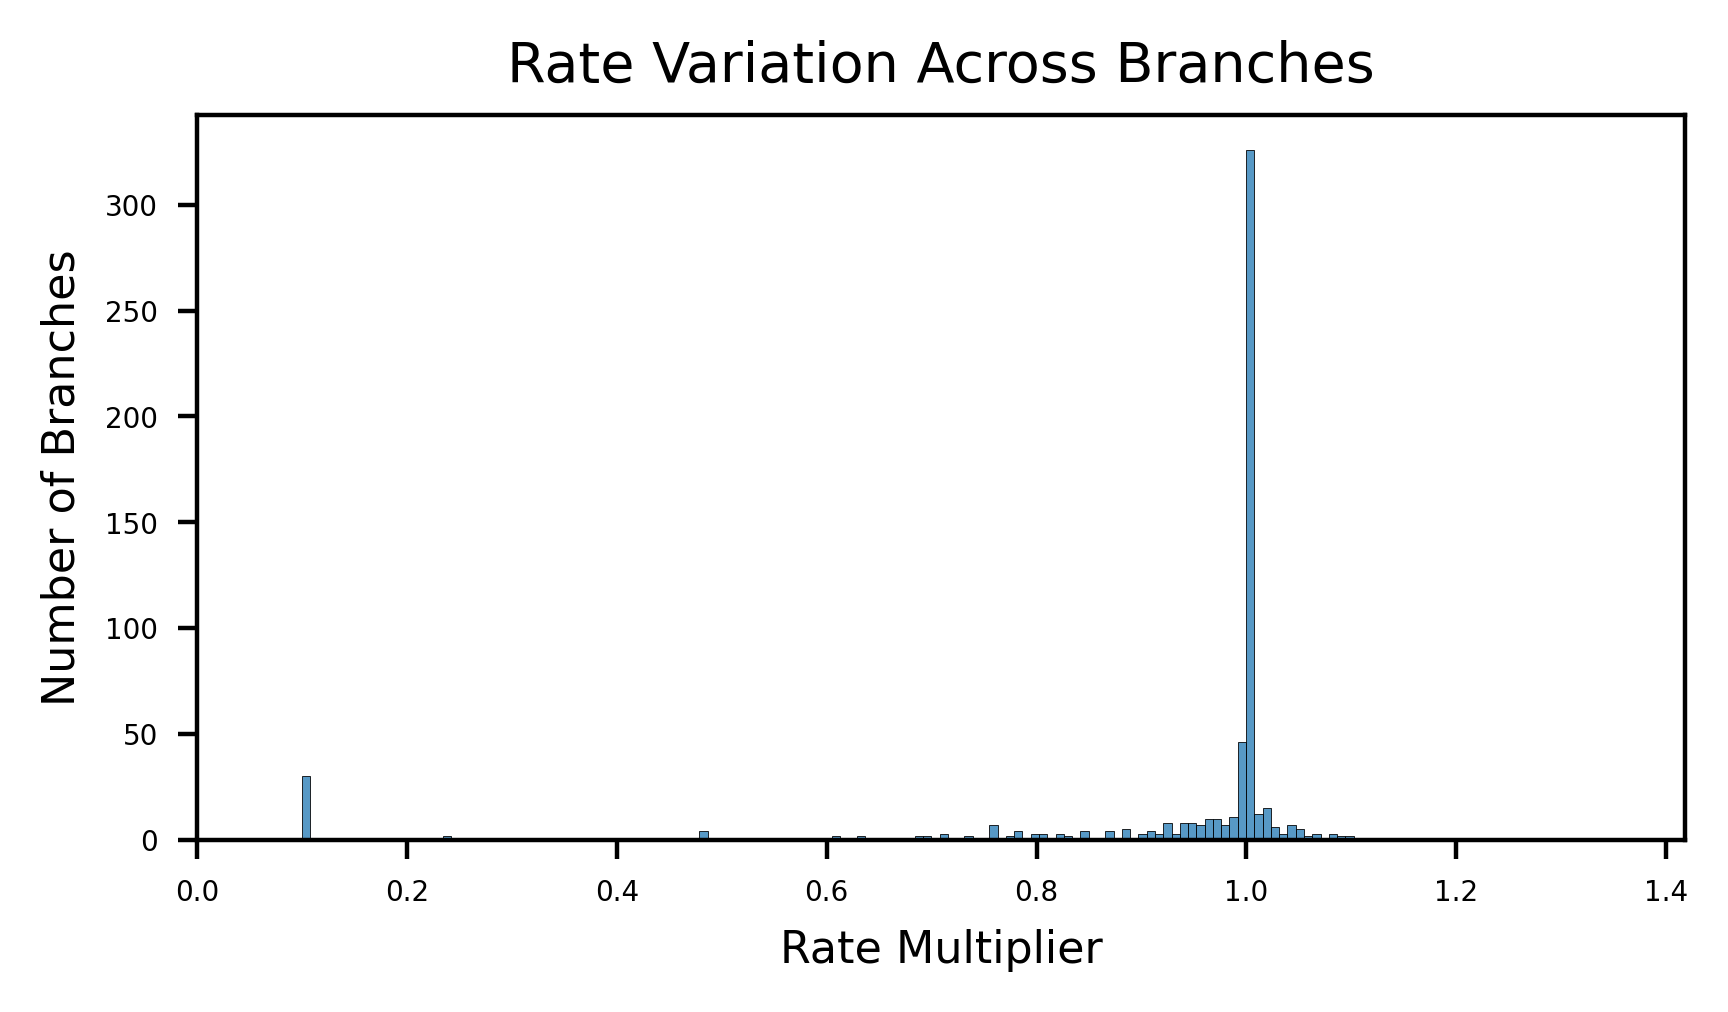

In [48]:
# Setup axis
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize_mini)

# Plot the histogram
# troubleshoot the disappearing nodes!

min_gamma = ['', 1]
max_gamma = ['', 1]
gamma_dict = {}
    
for rec in tip_data.iterrows():
    sample = rec[0]
    data = rec[1]
    g = tip_data["timetree_rate_fold_change"][sample]
    if g <= min_gamma[1]:
        min_gamma[0] = sample
        min_gamma[1] = g
    if g >= max_gamma[1]:
        max_gamma[0] = sample
        max_gamma[1] = g
    gamma_dict[sample] = g

sns.histplot(x = list(gamma_dict.values()), 
         ax=ax1,
         alpha=0.75,
         ) 

        
ax1.set_xlabel("Rate Multiplier")
ax1.set_ylabel("Number of Branches")
ax1.set_xlim(0,max_gamma[1])
ax1.set_title("Rate Variation Across Branches")

"""
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rate_variation." + FMT) 
plt.savefig(out_path, 
        dpi=dpi, 
        bbox_inches = "tight")"""